[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/16CQfmnO5SPZl0PdUqx6eqRIDKfo9OVug?usp=sharing)

# Práctica 8: Transfer learning

## Pre-requisitos

### Instalar paquetes

In [ ]:
# Hacemos los imports que sean necesarios
import numpy as np
import matplotlib.pyplot as plt
import torch
# Importa lightning si quieres utilizarlo

# Transfer learning sobre Stanford Dogs

Lo que queremos hacer es entrenar un clasificador para que catalogue las distintas clases de perros almacenadas en el dataset Stanford Dogs. Para ello, lo primero que tenemos que hacer es descargar y descomprimir el dataset.

In [ ]:
import urllib.request

print('Downloading...')
urllib.request.urlretrieve("https://www.kaggle.com/api/v1/datasets/download/jessicali9530/stanford-dogs-dataset", "stanford-dogs.zip")
print("Download complete! Unzipping...")

import zipfile
with zipfile.ZipFile("stanford-dogs.zip", "r") as zip_ref:
    zip_ref.extractall("stanford_dogs")
print("Your data is ready!")


El dataset ya está descargado en tu carpeta local (en Colab, puedes verlo en el icono de la carpeta que aparece a la izquierda).

### Paso a tensores de torch

Ahora cargaremos las imágenes en un dataset de tensores de torch. Necesitamos indicarle cómo adaptar cada imagen para procesarla con nuestra red. Para ello utilizaremos `torchvision.transforms` para crear una transformación que sea una composición de estas transformaciones sencillas:
1. Escalar todas las imágenes a un mismo tamaño ([Resize](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Resize.html))
1. Quedarnos solo con un cuadro central de 224x224 ([CenterCrop](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.CenterCrop.html))
1. Pasar a tensor ([ToTensor](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html))
1. Adaptar la escala de los valores para facilitar el entreno estandarizando los valores de los píxeles para que su distribución se asemeje a una N(0,1) ([Normalize](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Esto lo hacemos restando a cada pixel el valor medio de los píxeles en el conjunto Imagenet y dividiendo el resultado por la desviación típica de estos mismos píxeles.

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    # TODO Haz las transformaciones que se describen
])

# Load using ImageFolder
train_dir = "stanford_dogs/images/Images"
# TODO - Completa la llamada a ImageFolder
full_dataset = datasets.ImageFolder(root=train_dir, transform=...)

### Particiones de entrenamiento y test
Dejaremos el 20% de los datos para test. Utilizaremos `torch.utils.data.random_split` sobre `full_dataset` para conseguir dos datasets separados.

In [ ]:
from torch.utils.data import random_split

# random split (deterministic if you set generator seed)
train_subset, test_subset = ...

print(f"Train samples: {len(train_subset)}")
print(f"Test samples: {len(test_subset)}")
NUM_CLASSES = len(full_dataset.classes)
print(f"Number of classes: {NUM_CLASSES}")

Train samples: 16464
Test samples: 4116
Number of classes: 120


## Visualización

Echemos un vistazo a unas cuantas imágenes.

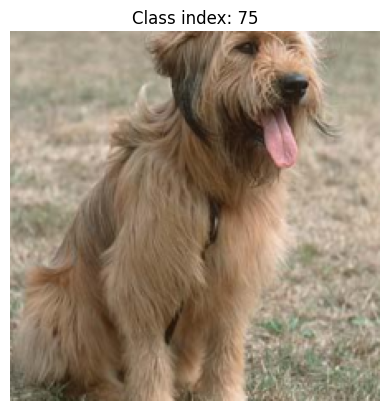

Image tensor shape: torch.Size([3, 224, 224])


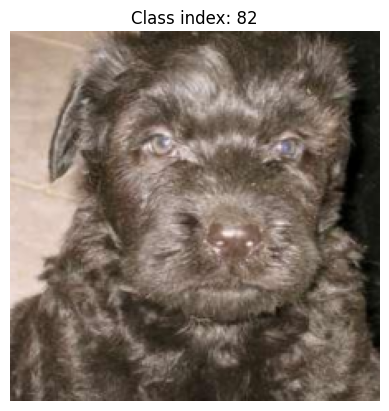

Image tensor shape: torch.Size([3, 224, 224])


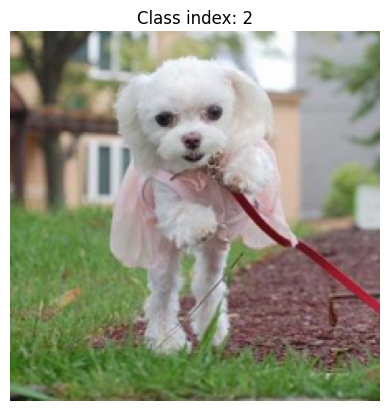

Image tensor shape: torch.Size([3, 224, 224])


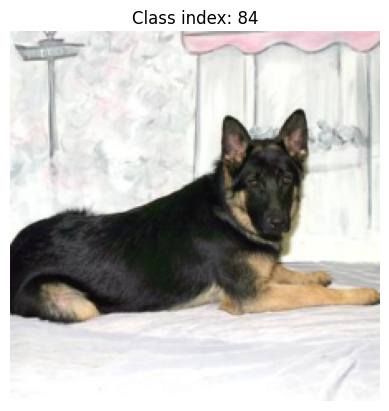

Image tensor shape: torch.Size([3, 224, 224])


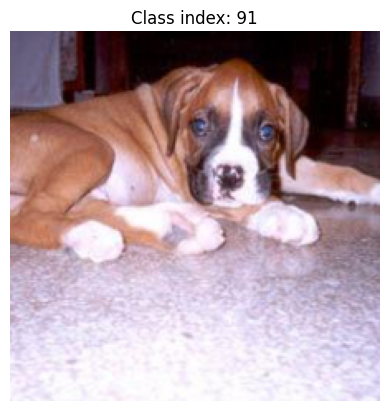

Image tensor shape: torch.Size([3, 224, 224])


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# TODO - Crea un DataLoader a partir del test_subset
test_loader  = ...

def show_image(image_tensor, label_tensor):
  # Unnormalize
  mean = torch.tensor(IMAGENET_MEAN)
  std = torch.tensor(IMAGENET_STD)
  img = image_tensor.permute(1, 2, 0) * std + mean  # CHW → HWC and undo normalization
  img = img.clamp(0, 1)  # keep in [0,1] for matplotlib

  # Show image and print details
  plt.imshow(img.numpy())
  plt.title(f"Class index: {label_tensor.item()}")
  plt.axis("off")
  plt.show()

  print(f"Image tensor shape: {images[0].shape}")

# Get one batch from the train_loader
images, labels = next(iter(test_loader))

for i in range(5):
  # Pick one example
  img = images[i]
  label = labels[i]

  show_image(img, label)

## Creando el modelo

Una vez sabemos preparar debidamente los datos, vamos a crear el modelo. Nuestro modelo constará de tres partes diferenciadas:

1. Data augmentation
1. DenseNet121 preentrenado
1. Clasificador

Vamos a ir paso a paso creando cada uno de los puntos.

### Data augmentation

El primer paso que vamos a realizar es aumentar los datos de entrenamiento mediante la aplicación de distintas transformaciones sobre las imágenes originales. En concreto, vamos a realizar las siguientes operaciones:

1. Rotaciones aleatorias de $2*\pi*0.15$ grados ([RandomRotation](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomRotation.html))
1. Traslaciones aleatorias del $10\%$ del tamaño de la imagen ([RandomAffine](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html))
1. Giros aleatorios de la imagen ([RandomHorizontalFlip](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomHorizontalFlip.html))
1. Cambios aleatorios del contraste del $10\%$ ([ColorJitter](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html))

La transformación de *data augmentation* será una nueva transformación [Compose](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) que haga esas operaciones. Cambia la `transform` de `train_subset` por una nueva `Compose` que haga la *data augmentation* seguida de la transformación original.

In [ ]:
# Transformación de data augmentation
img_augmentation = ...

# Cambia la transform del train_subset según lo descrito
train_subset.transform = ...

# Crea un dataloader a partir de train_subset
train_loader = ...

### Descargar un modelo preentrenado


Lo primero que vamos a hacer es descargar un modelo preentrenado. Por suerte, en TorchVision tenemos una serie de modelos ya preentrenados. Se encuentran en el paquete `torchvision.models` ([Doc](https://docs.pytorch.org/vision/main/models.html)). En concreto, vamos a utilizar la red DenseNet121, cuyo esquema podemos ver en la siguiente imagen:

![](https://drive.google.com/uc?export=view&id=1cINnKtOxOtZGxCiZwSXfhku495KHsSvk)

En esencia, es una variante del bloque residual, en donde la salida de una capa se suma a todas las salidas de las capas siguientes.

Para cargar el modelo haremos lo siguiente:

In [ ]:
from torchvision import models
# Cargamos la DenseNet121 preentrenada en ImageNet
densenet = models.densenet121(pretrained=True)


En la [documentación](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html) podemos ver que esta red admite, como entrada, imágenes de tamaño 224x224x3. Aunque podemos utilizar cualquier tamaño de entrada (siempre que sea mayor de 32x32x3), vamos a seguir utilizando ese tamaño.

### Crear el clasificador

Para crear el clasificador, lo que vamos a hacer es crear una última capa que será un clasificador lineal. Sin embargo, podemos observar que la salida de la red DenseNet tiene 4 dimensiones, no 2 que es lo necesario para crear el clasificador. Aquí tenemos dos opciones para realizar la conversión:

1. Usar [Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.flatten.Flatten.html#flatten), en la que la dimensión 2 será de tamaño la multiplicación de las dimensiones 2, 3 y 4.
1. Usar GlobalPooling, colapsando las dimensiones 2 y 3, siendo por tanto la dimensión 2 de salida igual a la dimensión 4 de entrada.

Aquí podemos ver una imagen ilustrando la diferencia:

![](https://drive.google.com/uc?export=view&id=1I3a2v7cuEjAUVdlLENtCaIq-etCXriGT)

En nuestro caso, vamos a usar un GlobalPooling, en concreto [AdaptiveAveragePool2D](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.adaptive_avg_pool2d.html). A mayores, añadiremos alguna regularización extra como [Dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html) o [Batch Normalization](https://docs.pytorch.org/docs/stable/generated/torch.ao.nn.quantized.BatchNorm1d.html).

In [ ]:
# TODO - Define un modelo con:
    # GlobalAveragePooling2D
    # BatchNormalization
    # Dropout con probabilidad 0.2
    # Dense con salida el número de clases del dataset
    # Softmax activation


### Combinando todos los elementos

Una vez creados todos los elementos, sólo nos falta combinarlos. Hay que recordar que la red preentrenada no se modifica, por lo que hay que indicarle que los pesos no son entrenables. Después desecharemos la capa de clasificación de la red y 

In [ ]:
# Congelamos los pesos de la densenet
for param in densenet.parameters():
    param.requires_grad = False  # freeze all backbone layers

# DenseNet121 tiene dos partes diferenciadas: `densenet.features` que calcula 1024 features a partir de cada imagen
# y densenet.clasifier, que (tras pasarles una ReLU) las utiliza para hacer la predicción sobre Imagenet
# Es esta última parte la que desecharemos
# Haremos un nuevo modelo que coja las capas de densenet.features y le concatene la ReLU final
# Este será el "backbone", la parte preentrenada, de nuestro modelo de clasificación
backbone = torch.nn.Sequential(*list(densenet.features.children()))
backbone.add_module('relu', torch.nn.ReLU(inplace=True))

# TODO - Crea tu modelo como un Sequential que concatene el backbone con el clasificador que
# has declarado en la celda anterior
model = ...

# Verificación
print(model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        

## Entrenando el modelo

Por último, sólo nos queda entrenar el modelo durante 10 iteraciones (ten paciencia, puede llevar sobre 10 minutos). En test, deberíamos tener una precisión cercana al $80\%$. Utiliza `nn.CrossEntropyLoss` como función de pérdida y Adam con lr=0.001 como optimizador (**recuerda que solo le debes pasar los parámetros de la parte clasificadora del modelo**).

Epoch [1/5] - Loss: 4.2853, Accuracy: 61.52%
Epoch [2/5] - Loss: 4.0388, Accuracy: 80.35%
Epoch [3/5] - Loss: 3.9906, Accuracy: 84.27%
Epoch [4/5] - Loss: 3.9694, Accuracy: 85.72%
Epoch [5/5] - Loss: 3.9535, Accuracy: 86.99%


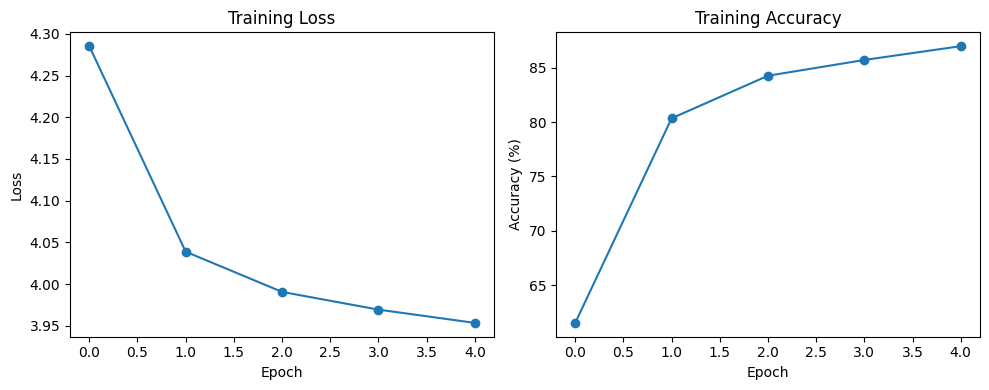

In [ ]:
# TODO - Entrena el modelo

## Fine tuning

Al inicio hemos entrenado el modelo sin tocar los pesos de la red DenseNet. Sin embargo, ahora que ya hemos entrenado las capas finales, podemos reentrenar el modelo al completo. Sin embargo, hay que tener en cuenta una serie de consideraciones.

- La tasa de aprendizaje tiene que ser muy baja. Un valor alto podría eliminar la calidad del entrenamiento inicial, haciendo que el sistema se comporte de manera similar a entrenarlo desde 0.
- Las capas de Batch Normalization se mantienen sin entrenar. Esto es debido a que dificultan el entrenamiento en redes ya entrenadas, y sólo estamos buscando un ajuste fino en el sistema.

In [ ]:
# TODO - Descongela las capas del backbone con un bucle similar al que
# utilizaste para congelar.

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 5

# Lists to store metrics
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

Epoch [1/5] - Loss: 3.9284, Accuracy: 89.03%
Epoch [2/5] - Loss: 3.9117, Accuracy: 90.49%
Epoch [3/5] - Loss: 3.8990, Accuracy: 91.64%
Epoch [4/5] - Loss: 3.8914, Accuracy: 92.26%
Epoch [5/5] - Loss: 3.8844, Accuracy: 92.83%


La precisión en entrenamiento ha subido, pero en test ha bajado. ¿Qué puede estar pasando?

# ¡ENHORABUENA! Has completado la práctica de Transfer Learning.

# ¿Deseas saber más?

El transfer learning no se limita sólo a entrenar las últimas capas. Se pueden utilizar sólo unas pocas capas preentrenadas, y entrenar el resto. No hay límite sobre lo que se puede hacer. Tampoco se restringe a clasificación únicamente. Las *deep features* de un modelo de clasificación suelen ser útiles para modelos de regresión, segmentación, etc.

# Trabajo extra

Como trabajo extra, se propone realizar una idea parecida, pero con dificultad añadida.

- El dataset a utilizar será [cifar10](https://www.tensorflow.org/datasets/catalog/cifar10).
- Se utilizará una entrada de la red de 32x32x3.
- La red preentrenada a utilizar será [MobileNetV3Small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small).
- Puedes escoger el clasificador que quieras.

In [ ]:
!nvidia-smi

Mon Oct 20 11:05:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             30W /   70W |    4922MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# TODO: escribe el código para el trabajo extra sin ayuda. Usa todos los bloques de código que quieras.